In [1]:
import segno
import os
import random
import io
import string
from tqdm import tqdm
from pyzbar.pyzbar import decode
from PIL import Image
import numpy as np
import cv2
from segno import consts
import string
from qreader import QReader
from skimage import restoration

RETRIES = 3
SCALE = 12
BORDER = 20
background_folder = r"..\..\..\checker\src\backgrounds"
qr_reader = QReader()

def preload():
    # preload backgrounds
    res = []
    background_files = os.listdir(background_folder)
    for background_file in background_files:
        path = os.path.join(background_folder, background_file)
        res.append(cv2.imread(path))

    # preload mask by emulating one holing process
    flag = 'ENO'+''.join(random.choices(string.ascii_letters +
                                        string.digits + '\/=', k=48))
    qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    qr_size = qr.symbol_size(scale=SCALE, border=BORDER)
    keep_modules = (consts.TYPE_FINDER_PATTERN_DARK, consts.TYPE_FINDER_PATTERN_LIGHT, consts.TYPE_SEPARATOR,
                    consts.TYPE_ALIGNMENT_PATTERN_DARK, consts.TYPE_ALIGNMENT_PATTERN_LIGHT, consts.TYPE_TIMING_DARK,
                    consts.TYPE_TIMING_LIGHT)
    border_offset = BORDER * SCALE
    d = SCALE // 3
    qr_size_small = qr.symbol_size(scale=SCALE, border=0)
    mask_image = np.zeros((qr_size_small[1], qr_size_small[0]), dtype=np.uint8)
    for i, row in enumerate(qr.matrix_iter(scale=SCALE, border=BORDER, verbose=True)):
        for j, m in enumerate(row):
            # if qr_code keep_modules goes here make it transparent
            if m in keep_modules:
                mask_image[j-border_offset, i-border_offset] = 255
            # if in qr code and not in border
            if (i > border_offset and j > border_offset) and (i < qr_size[0] - border_offset and j < qr_size[1] - border_offset):
                if (((i // d) % 3 == 1) and ((j // d) % 3 == 1)):
                    mask_image[j-border_offset, i-border_offset] = 255
    mask_image = cv2.copyMakeBorder(mask_image, border_offset, border_offset,
                                    border_offset, border_offset, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return res, mask_image


preloaded_backgrounds, preloaded_mask = preload()



In [26]:

def create_qr_code(flag, img_indx=0, scale=SCALE, border=BORDER) -> bytes:
    border_offset = border * scale
    qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    qr_image = None
    final_image = preloaded_backgrounds[img_indx].copy()
    output = io.BytesIO()
    qr.save(output, kind='png', scale=scale, border=0)
    # Reset the pointer to the beginning of the BytesIO object
    output.seek(0)
    qr_image = Image.open(output).convert('RGB')
    qr_image = np.array(qr_image)
    qr_image = cv2.copyMakeBorder(qr_image, border_offset, border_offset,
                                    border_offset, border_offset, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    heatmap = preloaded_mask == 255
    final_image[heatmap] = qr_image[heatmap]
    return final_image


def read_qr_code(image) -> str:
    decoded = qr_reader.detect_and_decode(image)
    if decoded:
        return decoded[0]
    return None


def pyzbar_read_qr_code(image) -> str:
    decoded = decode(image)
    if decoded:
        return decoded[0].data.decode('utf-8')
    return None




In [2]:
blur_sigma = 6  # Standard deviation for Gaussian kernel
kernel_size = 15  # Kernel size used for blurring
kernel_1d = cv2.getGaussianKernel(kernel_size, blur_sigma)
kernel = np.outer(kernel_1d, kernel_1d.transpose())
def blur(image):
    blurred_img = np.zeros_like(image, dtype=np.float32)
    for i in range(3):
        blurred_img[:, :, i] = cv2.filter2D(image[:, :, i], -1, kernel)
    blurred_img_float = blurred_img.astype(float) / 255.0
    return blurred_img_float

def unblur(image):
    restored_img = np.zeros_like(image)
    for i in range(3):
        # restored_img[:, :, i] = restoration.richardson_lucy(
        #     blurred_img_float[:, :, i], kernel, num_iter=100)
        restored_img[:, :, i] = restoration.wiener(
            image[:, :, i], kernel, 0.01, clip=False)
    restored_img = np.clip(restored_img, 0, 1)
    restored_img = (restored_img * 255).astype(np.uint8)
    return restored_img

cv2.imshow('image', blur(preloaded_backgrounds[0]))
cv2.imshow('image2', unblur(blur(preloaded_backgrounds[0])))
cv2.waitKey(0)

-1

In [28]:
data = {}
iters = 10
length = len(preloaded_backgrounds)
for i in tqdm(range(length)):
    data[i] = 0
    for j in range(iters):
        qr_code = create_qr_code('ENO' + ''.join(random.choices(string.ascii_letters +
                                                                string.digits + '\/=', k=48)), i)
        blurred = blur(qr_code)
        unblurred = unblur(blurred)
        decoded = read_qr_code(unblurred)
        # decoded = pyzbar_read_qr_code(qr_code)
        if decoded:
            data[i] += 1
        


100%|██████████| 35/35 [08:10<00:00, 14.02s/it]


In [29]:
import json
with open('kernel_test.json', 'w') as f:
    json.dump(data, f, indent=4, sort_keys=True)
    
with open('kernel_test.json', 'r') as f:
    data = json.load(f)


C:\Users\a_misc\AppData\Local\Temp\ipykernel_1800\2804513316.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


['3', '18', '22', '25', '26', '28', '30', '31', '33', '34']


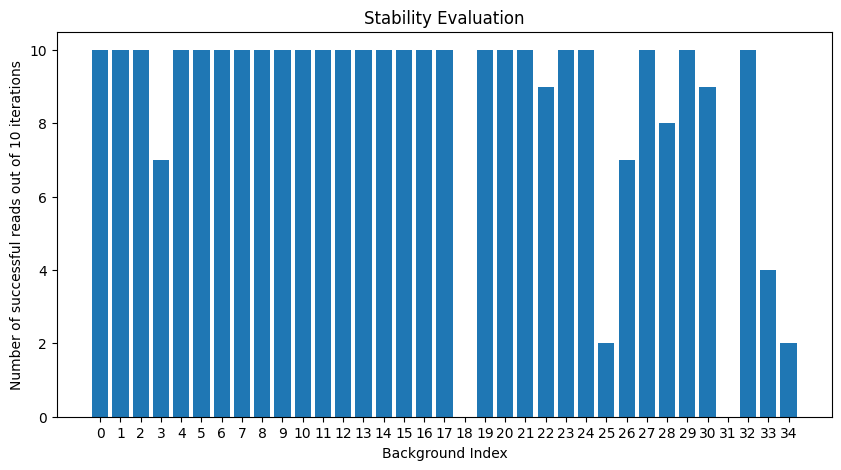

In [31]:
import matplotlib.pyplot as plt
plot, axs = plt.subplots(1,1,figsize=(10,5))
axs.set_title('Stability Evaluation')
axs.set_xlabel('Background Index')
axs.set_ylabel(f'Number of successful reads out of {iters} iterations')
axs.bar(data.keys(), data.values())
plot.show()
# print index whoes values is not iters
to_check = [k for k, v in data.items() if v != iters]
print(to_check)
for i in to_check:
    cv2.imshow(f'CHECK index {str(i)}',preloaded_backgrounds[int(i)])
cv2.waitKey(0)
cv2.destroyAllWindows()
